# Normalizing flows con Rational Quadratic Spline in Tensorflow probability

Con questo notebook illustriamo le proprietà della classe NeuralSplineFlow.

## Installazione e pacchetti

Installiamo la nostra repository GitHub e i pacchetti di python necessari.

In [ ]:
! git clone https://github.com/MarcoRiggirello/diglm.git

In [ ]:
import os
import sys

py_file_location = "diglm/diglm"
sys.path.append(py_file_location)

import numpy as np
from matplotlib import pyplot as plt
import sklearn.datasets as skd
import tensorflow as tf
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

from spqr import NeuralSplineFlow as NSF

## Il modulo *spqr*

Nel modulo `spqr` abbiamo cosruitp una *Neural Spline Flow* come nell'articolo di [Durkan et al.](https://arxiv.org/pdf/1906.04032.pdf) (sezioni 3.1-3.2).

Essa è una trasformazione biettiva costruita a partire da due RealNVP. I parametri della funzione biettia sono allenabili secondo classici modelli di Machine Learning. 


Inizializziamo la trasformazione biettiva e i vettori dello spazio latente:

In [ ]:
neural_spline_flow = NSF(splits=4)

In [ ]:
base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([1., 1.]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)

... e infine quella trasformata

In [ ]:
transformed_distribution = tfd.TransformedDistribution(distribution=base_distribution, bijector=neural_spline_flow)

## **Dataset**

Prendendo ispirazione dalla guida [FFJORD demo](https://www.tensorflow.org/probability/examples/FFJORD_Demo) creiamo il dataset della distribuzione a mezzalune

In [ ]:
DATASET_SIZE = 1024 * 32
BATCH_SIZE = 256
SAMPLE_SIZE = DATASET_SIZE

moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]

moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.shuffle(DATASET_SIZE)
moons_ds = moons_ds.batch(BATCH_SIZE)

### plotting utilities

In [ ]:
def plot(
    samples, transformed_samples,
    dataset):
  x_s, y_s = np.squeeze(np.split(samples, 2, axis=1))
  x_t, y_t = np.squeeze(np.split(transformed_samples, 2, axis=1))
  x_d, y_d = np.squeeze(np.split(dataset, 2, axis=1))
  
  fig, (ax_s, ax_t, ax_d) = plt.subplots(ncols=3, figsize=(12, 4))

  GRIDSIZE = 32
  CMAP = "magma"

  hb_s = ax_s.hexbin(x_s, y_s, gridsize=GRIDSIZE, bins="log", cmap=CMAP)
  ax_s.set(xlim=(x_s.min(), x_s.max()), ylim=(y_s.min(), y_s.max()))
  ax_s.set_title("Normal")
  cb_s = fig.colorbar(hb_s, ax=ax_s, label="log10(N)")

  hb_t = ax_t.hexbin(x_t, y_t, gridsize=GRIDSIZE, bins="log", cmap=CMAP)
  ax_t.set(xlim=(x_t.min(), x_t.max()), ylim=(y_t.min(), y_t.max()))
  ax_t.set_title("Transformed")
  cb_t = fig.colorbar(hb_t, ax=ax_t, label="log10(N)")

  hb_d = ax_d.hexbin(x_d, y_d, gridsize=GRIDSIZE, bins="log", cmap=CMAP)
  ax_d.set(xlim=(x_d.min(), x_d.max()), ylim=(y_d.min(), y_d.max()))
  ax_d.set_title("Target")
  cb_d = fig.colorbar(hb_d, ax=ax_d, label="log10(N)")

  plt.tight_layout()
  plt.show()

## **Training del modello**

Definiamo alcune funzioni utili per il training e la sua visualizzazione (plagio selvaggio della guida FFJORD demo)

In [ ]:
LR = .6e-3
NUM_EPOCHS = 300

@tf.function
def train_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return loss

@tf.function
def get_samples():
  base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
  transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
  return base_distribution_samples, transformed_samples


E ora plottiamo la distribuzione base e trasformata

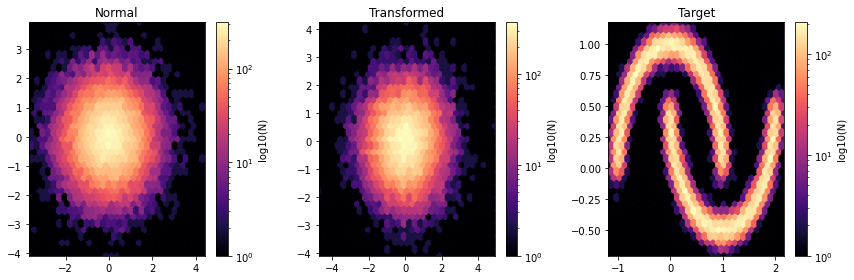

In [ ]:
evaluation_samples = []
base_samples, transformed_samples = get_samples()
evaluation_samples.append((base_samples, transformed_samples))

panel_id = 0
panel_data = evaluation_samples[panel_id]
plot(panel_data[0], panel_data[1], moons)

Ed ora, con grande ansia e poca speranza...

il training!!!

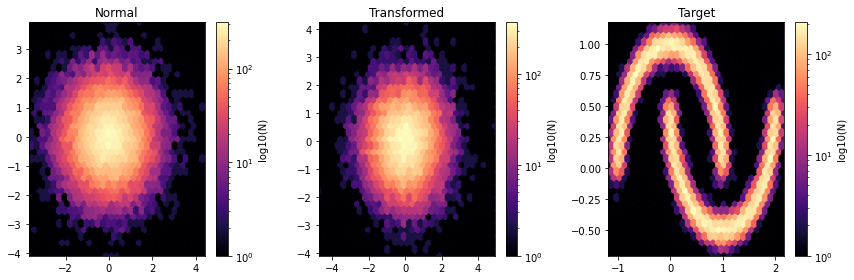

KeyboardInterrupt: ignored

In [ ]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 0
for epoch in range(NUM_EPOCHS):
  if epoch % 10 == 9:
    print(f"Epoch n. {epoch+1}. Loss={loss}.")
  base_samples, transformed_samples = get_samples()
  evaluation_samples.append((base_samples, transformed_samples))
  if epoch % 30 == 0:
    panel_data = evaluation_samples[epoch]
    plot(panel_data[0], panel_data[1], moons)
  for batch in moons_ds:
    loss = train_step(optimizer, batch)
    

Dunque la visualizzazione del risultato

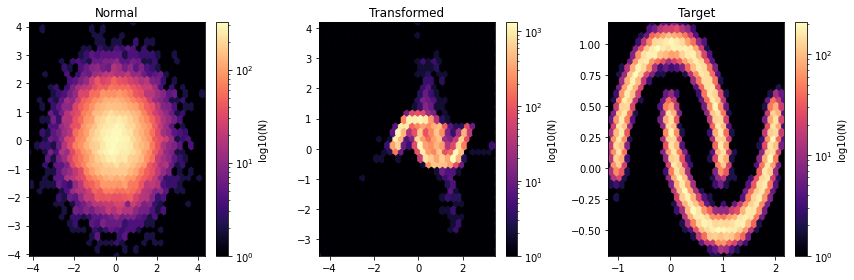

In [ ]:
panel_id = -1
panel_data = evaluation_samples[panel_id]
plot(panel_data[0], panel_data[1], moons)